- 1 Introduction
- 2 Load and check data
    - 2.1 load data
    - 2.2 Outlier detection
    - 2.3 joining train and test set
    - 2.4 check for null and missing values
- 3 Feature analysis
    - 3.1 Numerical values
    - 3.2 Categorical values
- 4 Filling missing Values
    - 4.1 Age
- 5 Feature engineering
    - 5.1 Name/Title
    - 5.2 Family Size
    - 5.3 Cabin
    - 5.4 Ticket
- 6 Modeling
    - 6.1 Simple modeling
        - 6.1.1 Cross validate models
        - 6.1.2 Hyperparamater tunning for best models
        - 6.1.3 Plot learning curves
        - 6.1.4 Feature importance of the tree based classifiers
    -  6.2 Ensemble modeling
        - 6.2.1 Combining models
    -6.3 Prediction
        - 6.3.1 Predict and Submit results

# 1. Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# LDA 선형 판별 분석
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier # 다층 신경망
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold,learning_curve

sns.set(style='white', context='notebook',palette='deep')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Load and check data

## 2-1. Load data

In [2]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
IDtest = test["PassengerId"]

## 2-2. Outlier detection

In [3]:
def detect_outliers(df,n,features):
    outlier_indices  = []

    for col in features:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3-Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col]<Q1 - outlier_step) | (df[col]>Q3+outlier_step)].index
        outlier_indices .extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k,v in outlier_indices.items() if v>n )

    return multiple_outliers

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp",'Parch',"Fare"])

Outlier는 예측에 영향을 미칠 수 있으므로 관리하기로 결정함.

Age, SibSp, Parch, Fare에서 이상치를 감지하기로 결정하고 이상치가 두개 이상인 행을 이상치 행으로 결정함.

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 outliers를 발견했음.
- 28, 89, 342 승객은 높은 Ticket Fare 값을 가지고 있음
- 다른 7명은 SibSp의 값이 높음.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop,axis = 0).reset_index(drop=True)

## 2-3. Joining train and test set

In [6]:
train_len = len(train)
dataset = pd.concat(objs = [train,test],axis =0).reset_index(drop=True)

훈련 데이터셋과 테스트 데이터셋을 join함 범주형 변환하는 동안 같은 수의 feature를 얻기 위해

## 2-4. Check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# check for null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin feature는 결측값의 대부분을 차지함.

Survived의 결측값은 테스트데이터셋에 해당됨.

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3-1. Numerical values

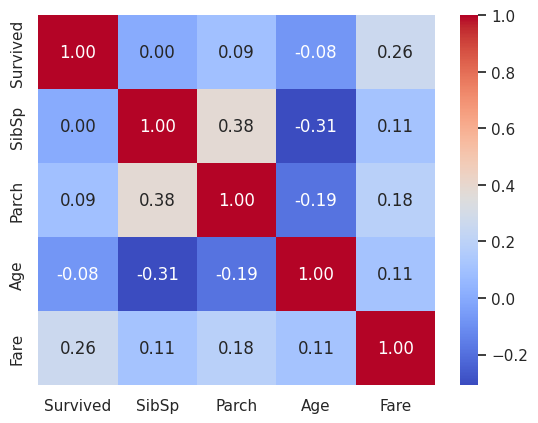

In [12]:
g= sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True, fmt = ".2f",cmap="coolwarm")

Fare만 Survived와 유의미한 상관관계가 있는 것으로 보임.

다른 feature이 유용하지 않다는 의미는 아님. 이러한 feature의 하위 모집단은 Survived와 상관관계가 있을 수 있음. 이를 결정하기 위해서는 feature를 자세히 살펴봐야함.

### 3-1-1. SibSp

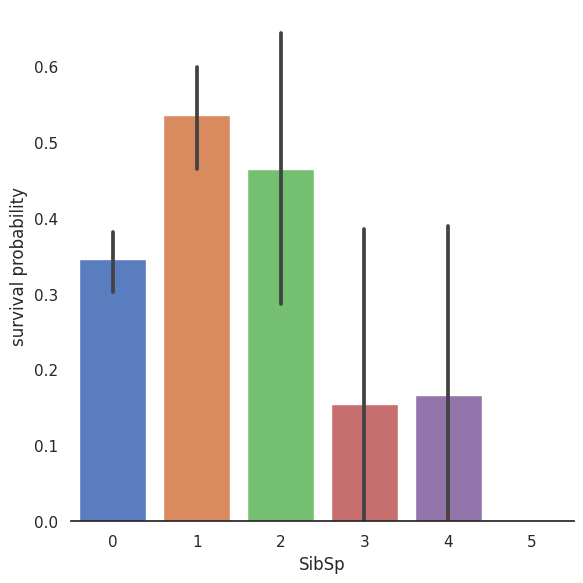

In [13]:
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar",height=6,palette="muted")
g.despine(left=True) # 위쪽 축과 오른쪽 축을 숨김.
g = g.set_ylabels("survival probability")

- 형제, 배우자가 많은 승객은 생존 가능성이 적은 것으로 보임.
- 한명의 승객(0 SibSp) 또는 다른 두명의 승객 (SibSp 1 or 2)는 생존할 확률이 높음.

### 3-1-2. Parch

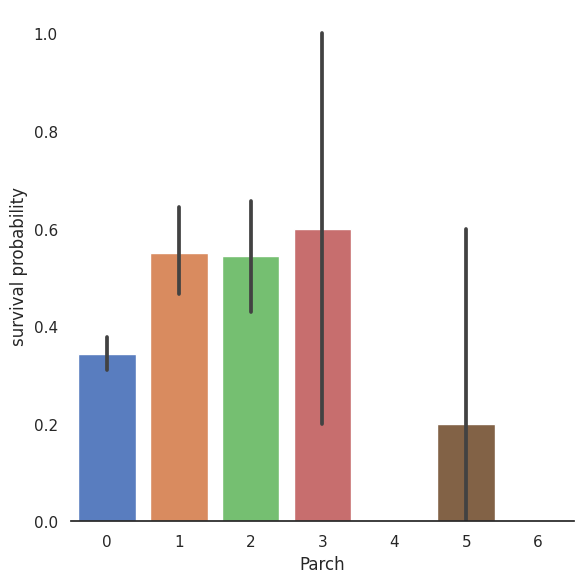

In [14]:
g = sns.catplot(x="Parch", y = "Survived", data = train, kind= "bar", height = 6, palette= "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 소규모 가족은 생존확률이 더 높음. 독신(Parch 0), 중간(Parch 3,4), 대가족(Parch 5,6)
- 부모/자녀가 3명인 승객의 생존에는 표준편차가 매우 크기 때문에 주의 해야함.

### 3-1-3. Age

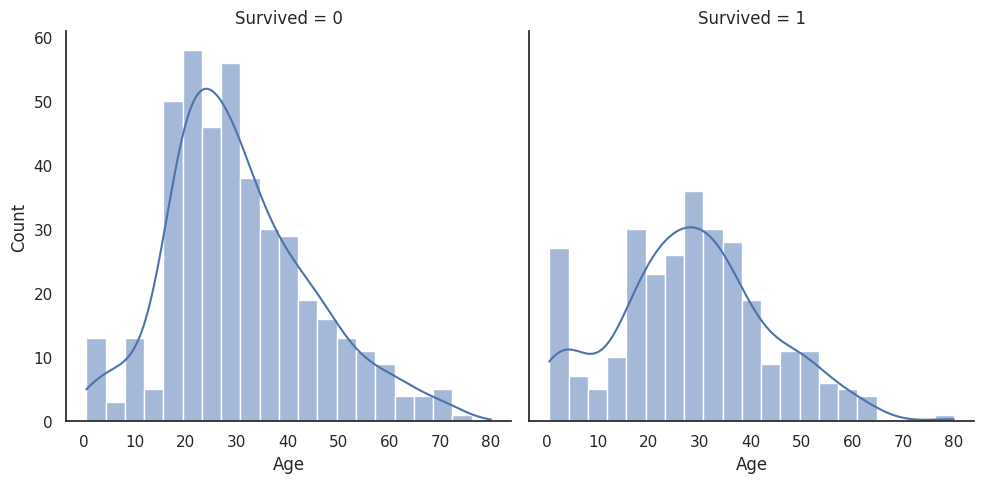

In [15]:
# Explore Age vs Survived
sns.displot(data = train, x ="Age", col = "Survived",kde = True)

- 생존한 집단과 생존하지 않은 집단의 연령 분포가 같지 않은 것을 확인할 수 있음.
- 실제로 젊은 승객에 해당하는 정점이 생존한 것으로 나타남.
- 또한 60-80세 사이의 승객이 생존한 경우가 적다는 것도 알 수 있음.
- 따라서 연령이 생존과 상관관계가 없더라도 생존 가능성이 어느 정도 높은 승객의 연령 범주가 있다는 것을 알 수 있음

- 아주 어린 승객은 생존할 수 있는 기회가 더 많은 것으로 보임.

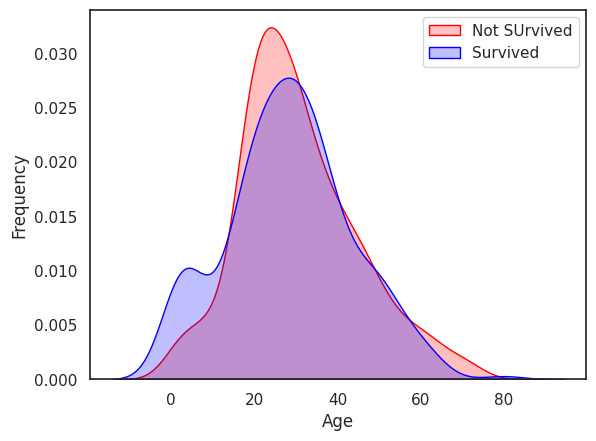

In [16]:
g = sns.kdeplot(train["Age"][(train["Survived"]==0) & (train["Age"].notnull())],
               color = "Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"]==1) & (train["Age"].notnull())],
               color = "Blue", shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not SUrvived", "Survived"])

### 3-1-4. Fare

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
# Fill Fare missing values with the median value

dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

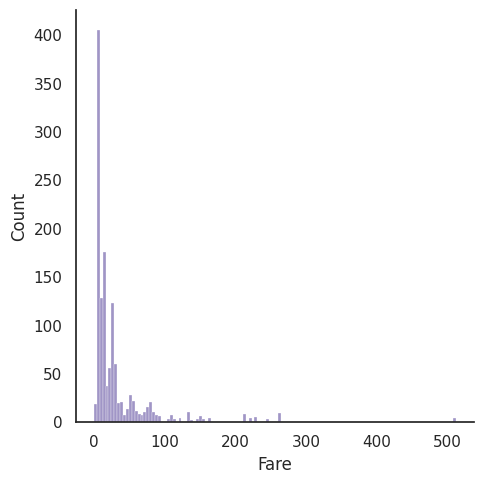

In [19]:
sns.displot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))

- Fare의 분포는 매우 왜곡되어있음. 이로 인해 규모가 축소되더라도 모델에서 가중치가 매우 높을 수 있음.
- 로그 함수로 변환하여 왜곡을 줄이는 것이 좋음.

In [20]:
# Apply log to Fare to reduce skewness distribution

dataset["Fare"] = dataset["Fare"].map(lambda i :np.log(i) if i >0 else 0)

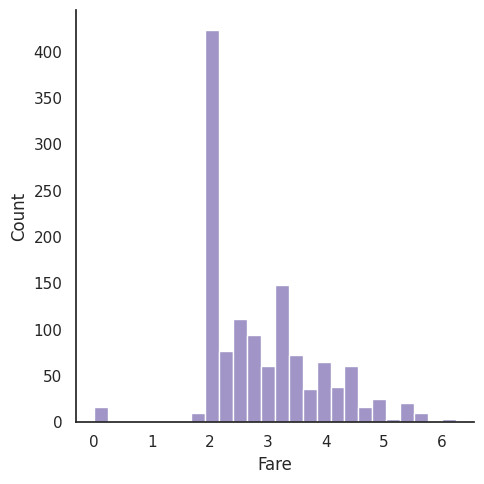

In [21]:
sns.displot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))

- 왜도가 확실히 감소한 것을 볼 수 있음.

## 3-2. Categorical values

### 3-2-1. Sex

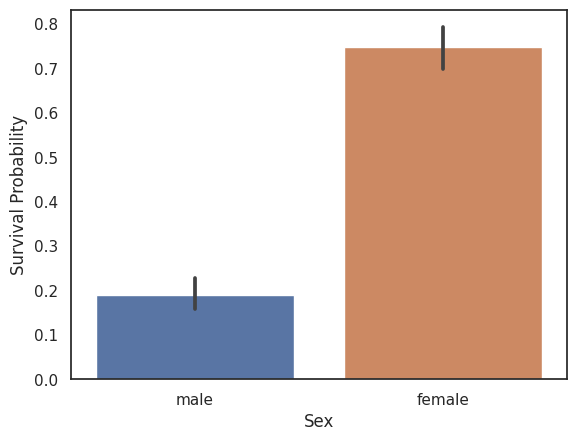

In [22]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [23]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 남성보다 여성이 훨씬 더 생존확률이 높은 것을 확인 할 수 있음.

### 3-2-2. Pclass

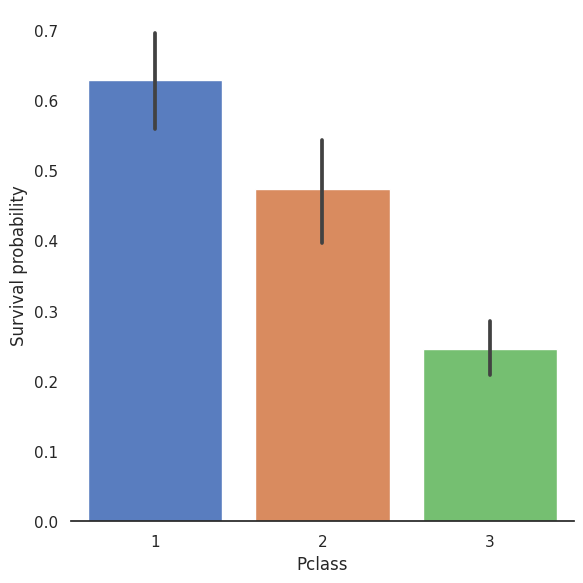

In [24]:
g = sns.catplot(x="Pclass",y="Survived",data = train,kind="bar",height=6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

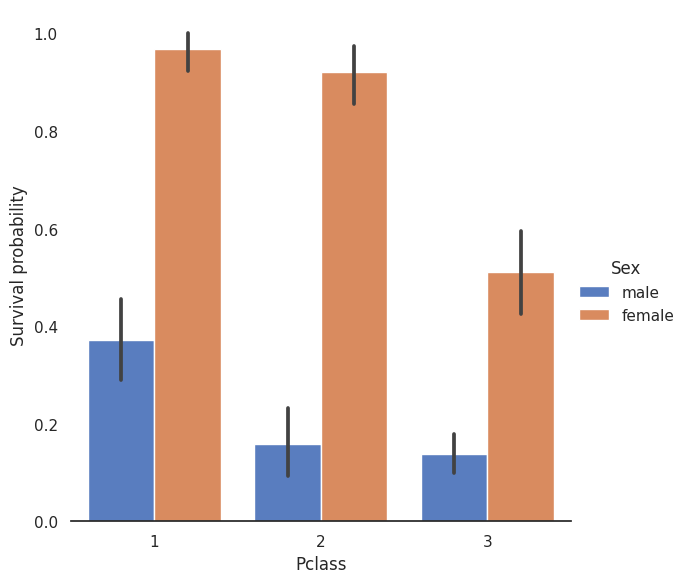

In [25]:
g = sns.catplot(x="Pclass",y="Survived",hue="Sex",data=train,height=6,kind="bar",palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 1등석 탑승객의 생존확률이 다른 칸보다 높음.
- 여성과 남성 모두 해당됨.

### 3-2-3. Embarked

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
### Fill Embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

2개의 결측값을 제일 최빈값인 S의 값으로 채워줌

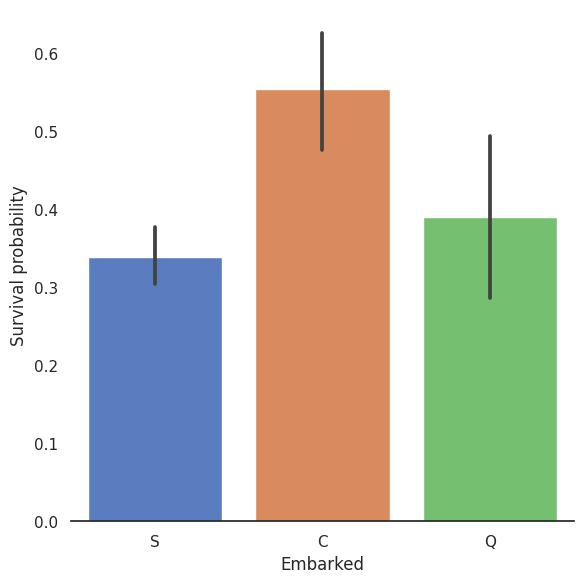

In [28]:
# Explore Embarked vs Survived

g = sns.catplot(x="Embarked",y="Survived",data = train, height=6,kind="bar",palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- C에서 탑승한 승객의 생존률이 높게 나타남.
- C에서 1등석 승객이 많이 탑승한 것으로 추측됨.

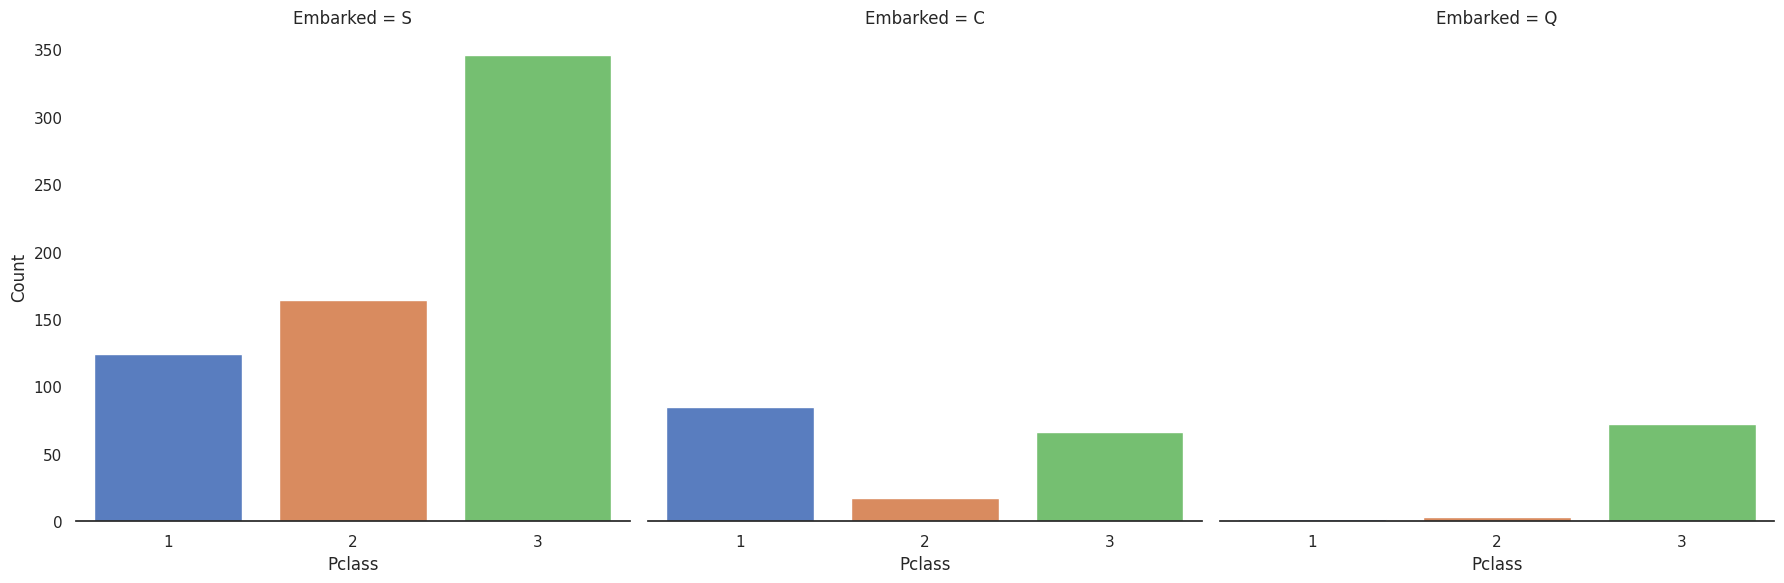

In [29]:
# Explore Pclass vs Embarked
g = sns.catplot(x="Pclass",col="Embarked",data=train,height=6,
               kind = "count",palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

- 3등석의 탑승객은 대부분 S와 Q 항구에서 탑승한것을 볼 수 있음
- C항구에서 1등석 승객의 탑승 비율이 높아서 생존확률이 높은 것으로 보임.

# 4. Filling missing values

## 4-1. Age

In [30]:
dataset['Age'].isnull().sum()

256

- Age 열은 256개의 결측값을 가지고 있음.
- 나이에 따라 생존확률이 높은 모집단이 있으므로 연령층을 유지하고 결측값을 채우는 것이 바람직할것으로 보임.
- Age와 상관관계가 큰 특성을 관찰할 필요가 있음(Sex, Parch, Pclass and SibSP)

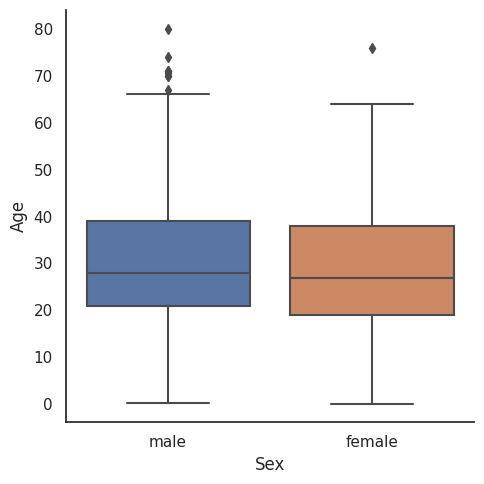

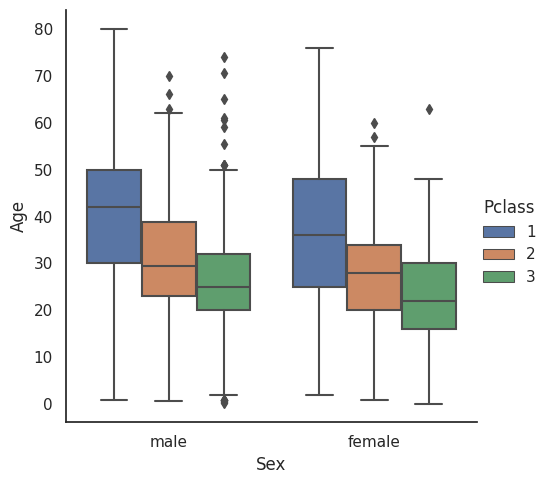

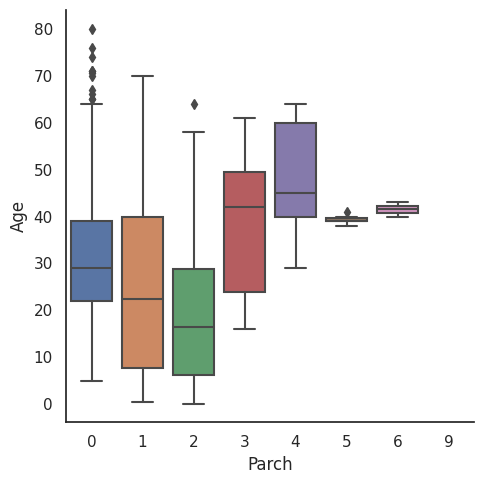

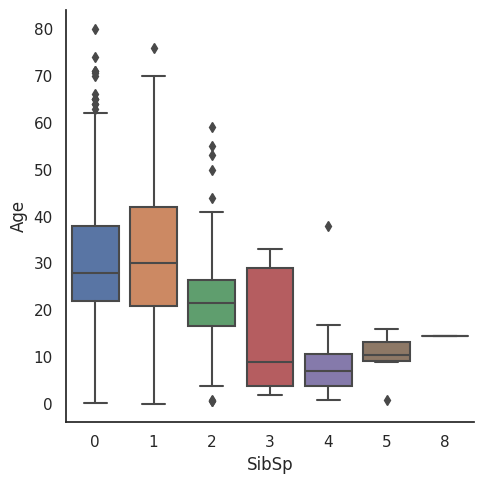

In [31]:
# Explore Age vs Sex, Parch, Pclass and SibSP

g = sns.catplot(y="Age",x="Sex",data = dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue = "Pclass",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch",data = dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp",data=dataset,kind="box")

- 연령분포는 여성과 남성에서 비슷하게 나타나므로 성별은 나이를 추측하기 중요한 특성이 아님
- 1등석 탑승자의 평균연령이 2등석, 3등석 탑승객의 나이보다 많은 것으로 보임
- 부모/자식의 수가 많을수록 평균연령이 높아지는 추세이고, 형제 자매가 많을 수록 평균연령이 낮아지는 추세임.

In [32]:
# convert Sex into categorical value 0 for male 1 for female

dataset["Sex"] = dataset["Sex"].map({"male":0,"female":1})

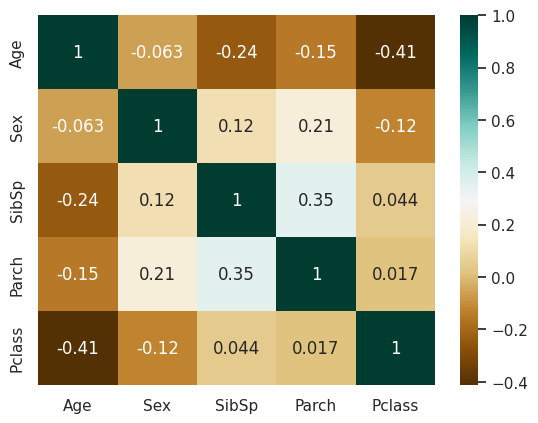

In [33]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

- 연령은 성별과 상관관계가 없지만, Pclass, Parch, SibSp와 음의 상관관계를 띄고 있음.
- Parch에 따른 연령에서 연령은 증가하는 추세를 보이지만 음의 상관관계를 가지고 있음.
- 누락된 연령 값을 대체하기 위해 SibSP, Parch, Pclass의 값을 사용하기로 함.
- Pclass, Parch, SibSp에 따라 유사한 행을 평균연령으로 채울 예정.

In [34]:
# filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp

# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"])&
                              (dataset["Parch"] == dataset.iloc[i]["Parch"]) &
                              (dataset["Pclass"] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/tmp/ipykernel_17/1519918780.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
/tmp/ipykernel_17/1519918780.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
/tmp/ipykernel_17/1519918780.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
/tmp/ipykernel_17/1519918780.py:14: SettingWithCopyWarning: 
A value is trying to be set on

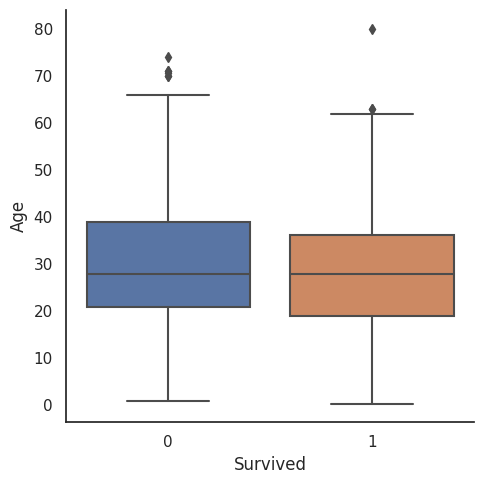

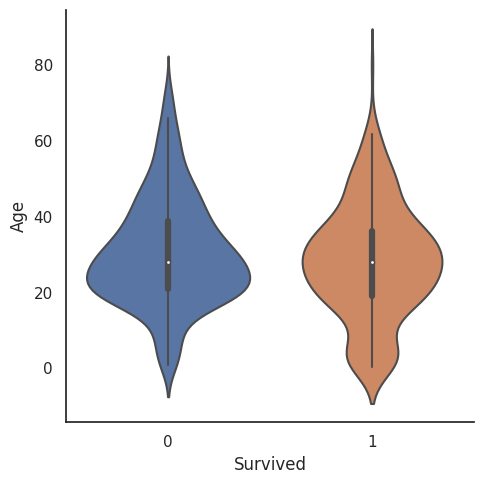

In [35]:
g = sns.catplot(x="Survived", y ="Age",data=train,kind="box")

g = sns.catplot(x="Survived",y="Age",data=train,kind="violin")

- 생존한 하위 모집단과 생존하지 못한 하위 모집단의 연령 중앙값 사이에는 차이가 없는 것으로 보임.
- 바이올린 플롯에서 보았을때는 연령이 아주 어린 탑승객의 생존률이 더 높은 것으로 보임.

# 5. Feature engineering

## 5-1. Name/Title

In [36]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- 이름에는 승객의 직함에 대한 정보가 포함되어있음
- 구조 시 특정 직함이 우선 구조가 될 가능성이 있으므로 직함을 모델에 포함시키도록함.

In [37]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

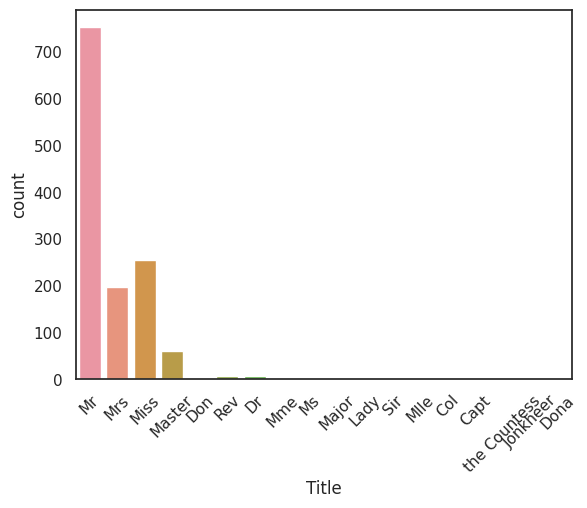

In [38]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(),rotation=45)

- 총 17개의 카테고리가 있으며 4개를 제외하고는 매우 드물게 나타나기 때문에 4개의 그룹으로 범주화 할 수 있음.

In [39]:
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [40]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess',
                                             'Capt', 'Col','Don', 'Dr', 'Major', 
                                             'Rev', 'Sir', 'Jonkheer', 'Dona'],
                                             'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 ,
                                         "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, 
                                         "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

In [41]:
dataset['Title'].value_counts()

Title
2    753
1    457
0     60
3     29
Name: count, dtype: int64

[Text(0, 0, 'Master'),
 Text(1, 0, 'Miss/Ms/Mme/Mlle/Mrs'),
 Text(2, 0, 'Mr'),
 Text(3, 0, 'Rare')]

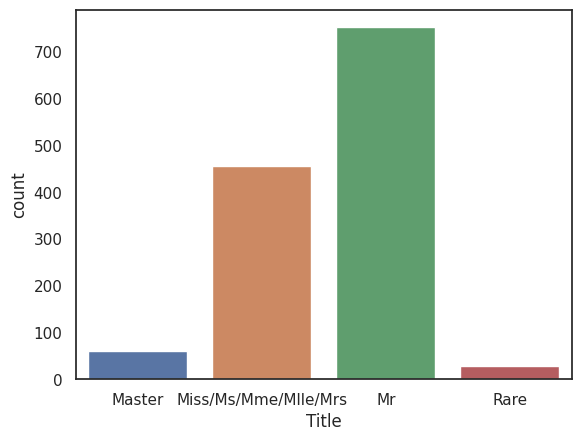

In [42]:
g= sns.countplot(x = dataset["Title"])
g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

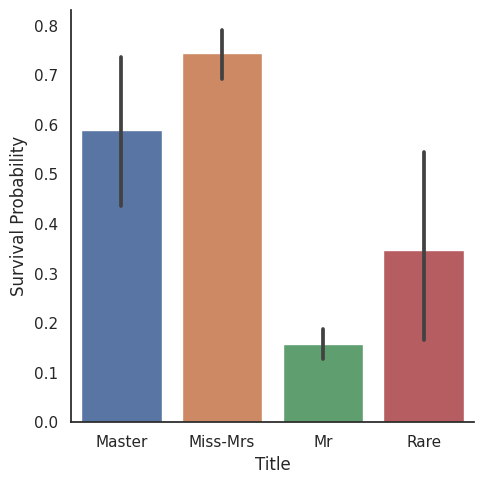

In [43]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("Survival Probability")

- 희귀한 타이틀을 가진 승객이 생존율이 높은점이 흥미로움.

In [44]:
# Drop Name variable
dataset.drop(labels = ["Name"],axis=1,inplace=True)

## 5-2. Family Size
- 대가족의 경우 그들의 형제/자매/부모를 찾는 동안 구조가 늦어질 수 있다는 점을 예상해볼 수 있음.
- Fsize(Family Size)라는 특성을 SibSp, Parch을 사용해서 만들기로 함.

In [45]:
# Create a family size descriptor from SibSp and Parch

dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


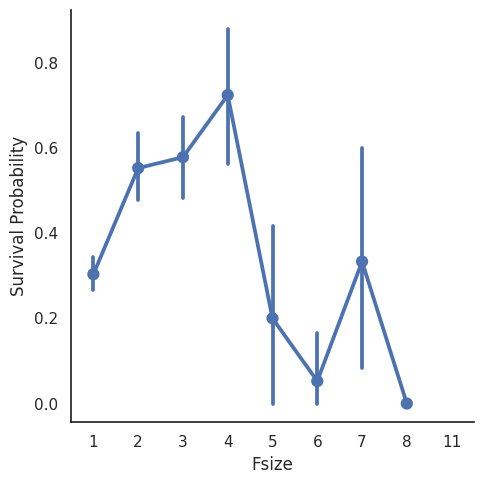

In [46]:
g = sns.catplot(x="Fsize",y="Survived",data=dataset,kind = "point")
g = g.set_ylabels("Survival Probability")

- Family Size는 중요한 역할을 하는 것으로 보임. 대가족의 경우 생존확률이 최악임.
- Family Size를 4가지 범주로 범주화.

In [47]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<= s <=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5  else 0)

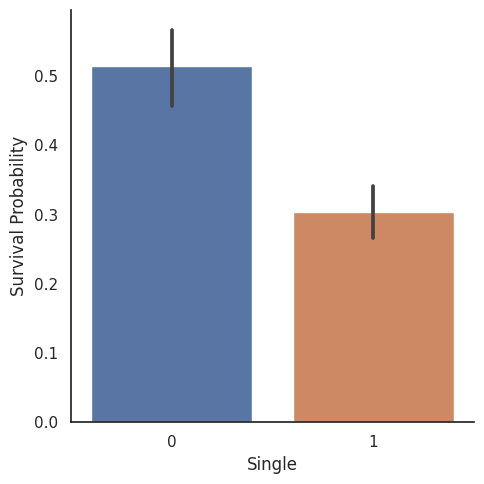

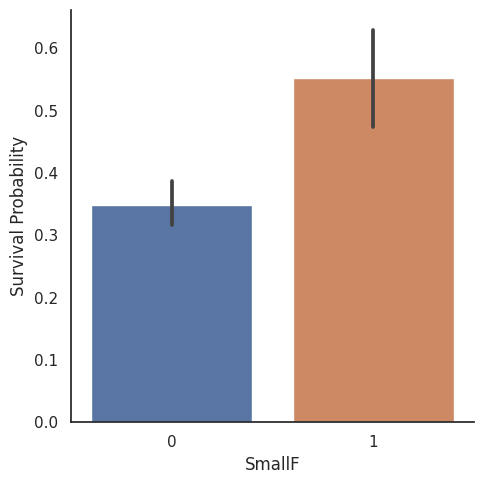

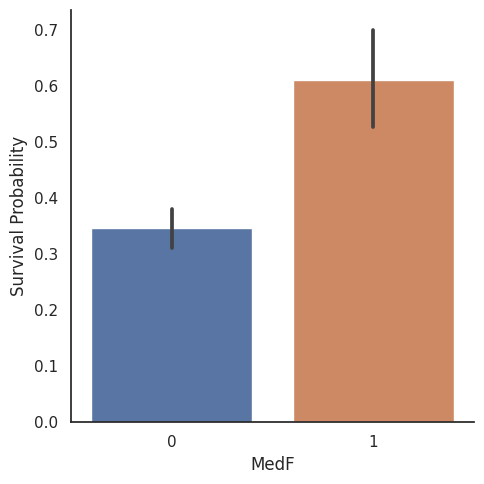

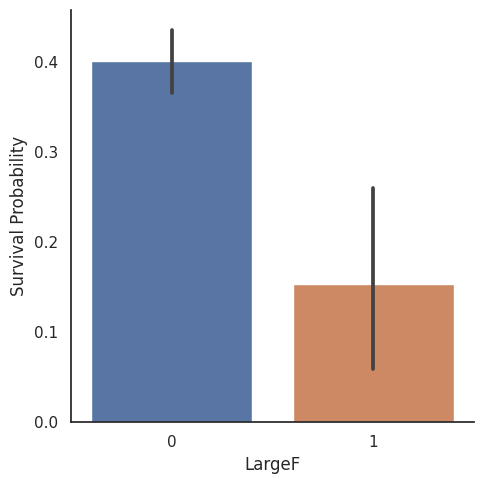

In [48]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

- 중.소형 가정이 1인가족 혹은 대가족보다 생존확률이 높은 것으로 보임.

In [49]:
# convert to indicator values Title and Embarked

dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"],prefix="Em")

In [50]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


## 5-3. Cabin

In [51]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [52]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [53]:
dataset["Cabin"].isnull().sum()

1007

- Cabin은 292개의 값와 1007개의 결측값으로 이루어져있음.
- 객실이 없는 승객의 경우 결측된 값으로 대체 되어 있다는 것으로 가정함.

In [54]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [55]:
# Replace the Cabin number by the type of cabin 'X' if not

dataset["Cabin"] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'])

Cabin의 첫번째 문자의 경우 Desk를 나타냄. 이 값은 타이타닉에서 승객이 어떤 위치에 탑승했는지를 확인할 수 있기 때문에 첫번째 문자만 남기기로 함.

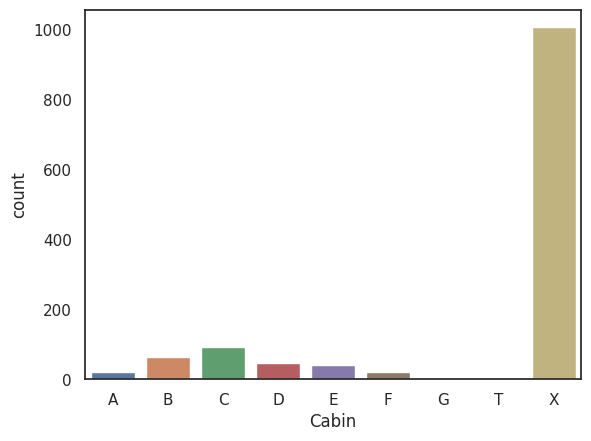

In [56]:
g = sns.countplot(x=dataset["Cabin"],order =['A','B','C','D','E','F','G','T','X'])